#IDA Simulation

In [ ]:
# library
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integ
import scipy.optimize as opti

%matplotlib inline

In [ ]:
# these constants are assumed not to change
mass_ball = 0.025  #kg
mass_platform= 0.0642  # kg
g =9.81  # m/s**2
dia_ball = 0.04  # m
rho = 1.164  # kg/m^3, density of air
mju = 1.872e-5  # kg/m.s, dynamic viscosity of air
mju_k_r2m = 0.5  # dimensionless, coefficient of kinetic friction rubber to metal
mju_k_p2m = 0.15  # dimensionless, coefficient of kinetic friction plastic to metal

# these parameter values can be changed
length_spring = 0.241 # m
k_spring = 225  # N/m, spring constant
init_v = 0   # m/s

# these parameter values main variable
angle = 40  # deg, launch angle
x_spring = 0.155  # m, spring compression

In [ ]:
total_mass = mass_ball+mass_platform

Formula to calculate displacement (taking origin as the launch location pin)

Default distance between launch location pin to bottom of the spring = 0.1 m (subject to change)

Angle of elevation between the launch location pin and the bottom of the spring = angle_0 = 40

Default length of spring = 0.241 m

Length of launcher platform = 0.15 m

In [ ]:
def displacement(angle=angle,dist_origin_to_spring=0.144,angle_0=45,spring_length=length_spring,compression_length=x_spring):
  """ This function return x0, y0, x1, y1, x2, y2 in tuple"""
  x0 = 0.09
  y0 = 0.25
  x1 = x0+(spring_length+0.015-compression_length)*np.cos(np.deg2rad(angle))
  y1 = y0+(spring_length+0.015-compression_length)*np.sin(np.deg2rad(angle))
  x2 = x0+0.306*np.cos(np.deg2rad(angle))
  y2 = y0+0.306*np.sin(np.deg2rad(angle))
  return x0, y0, x1, y1, x2, y2

In [ ]:
displacement()

(0.09,
 0.25,
 0.16737048875501678,
 0.3149215485783405,
 0.3244095995944073,
 0.446693008564081)

#Compression

In [ ]:
def friction_decompression():
  return mju_k_p2m*g*np.cos(np.deg2rad(angle))

In [ ]:
#Spring equation
def spring(y, t):
  #unpack array
  s, v = y
  #dsdt (spring compression length)
  dsdt = -v
  #dvdt
  dvdt = k_spring*s/total_mass - g*np.sin(np.deg2rad(angle)) - friction_decompression()
  return dsdt, dvdt

Finding maximum velocity (zero acceleration)

In [ ]:
def maxVelocity(t_end):
  t = np.linspace(0, t_end, 100)
  solution = integ.odeint(spring, y0, t)
  v, a = spring(solution[-1], t_end)
  return a

In [ ]:
# initial displacement and velocity
y0 = [x_spring, init_v]

def v_final(y0=y0):
  t_end = opti.newton(maxVelocity, 0.013)

  t = np.linspace(0,t_end,100)

  sol = integ.odeint(spring, y0, t)
  s = sol[:,0]
  v = sol[:,1]
  return v

In [ ]:
displacement()

(0.09,
 0.25,
 0.16737048875501678,
 0.3149215485783405,
 0.3244095995944073,
 0.446693008564081)

#Travelling in pipe

In [ ]:
def friction_pipe():
  return mju_k_r2m*g*np.cos(np.deg2rad(angle))


In [ ]:
def ballvel(x_spring,init_v=0):
  a=g*np.sin(np.deg2rad(angle))+friction_pipe()
  v_launch=((v_final(y0=[x_spring, init_v])[-1])**2-2*(a)*(0.306-length_spring-0.015))**0.5
  return v_launch

In [ ]:
ballvel(x_spring=x_spring)

7.570504339730513

# Trajectory

**N.B.**

"Initial" in this code refers to the conditions when the ball just leaves the pipe, not the conditions when it is held at the compressed spring.

Basic functions

In [ ]:
# return x, y, Vx, Vy and t arrays given certain input conditions
def trajectory(x_0, y_0, V_mag, theta, T=1):
    """
    Function accepts the initial position of the ball x_0 and y_0, the initial velocity magnitude of the ball V_mag, the initial
    angle between the velocity vector and the positive x-axis theta, and a time T, and returns arrays each corresponding to the 
    horizontal and vertical distance travelled by the ball x and y, and the horizontal and vertical components of the ball's 
    velocities Vx and Vy, for a time interval from 0 to T seconds
    """
    # calculate Reynolds number
    Re = rho * V_mag * dia_ball / mju
    
    # calculate drag coefficient
    Cd = 24/Re * (1 + 0.27*Re)**0.43 + 0.47 * (1 - np.exp(-0.04*Re**0.38))
    
    # calculate magnitude of drag force
    D_mag = 0.5 * rho * V_mag**2 * Cd * dia_ball**2 * np.pi / 4
    
    # calculate drag force components
    Dx = D_mag * np.cos(theta)
    Dy = D_mag * np.sin(theta)
    
    # calculate initial velocity components
    Vx_0 = V_mag * np.cos(theta)    
    Vy_0 = V_mag * np.sin(theta)
    
    # create time array
    t = np.linspace(0, T, 101)
    
    # function which computes RHS of ODEs
    def trajectory_func(u, t):        
        x, y, Vx, Vy = u        
        ax = - Dx/mass_ball     
        ay = - Dy/mass_ball - g   
        return [Vx, Vy, ax, ay]
    
    # pack initial conditions into u_0
    u_0 = [x_0, y_0, Vx_0, Vy_0]
    
    #integrate
    result = integ.odeint(trajectory_func, u_0, t)
    
    # unpack data
    x  = result[:, 0]
    y  = result[:, 1]
    Vx = result[:, 2]
    Vy = result[:, 3]
   
    # return x, y, Vx, Vy, and t arrays
    return x, y, Vx, Vy, t       

In [ ]:
# return x, y, Vx, Vy and t arrays when y reaches zero
def trajectory_with_stop(x_0, y_0, V_mag, theta):
    """
    Function accepts certain input conditions and returns arrays each corresponding to x, y, Vx, Vy and t after y becomes zero
    again
    """
    # return y at t=T from given initial conditions
    def find_y_at_T(T):
        x, y, Vx, Vy, t = trajectory(x_0, y_0, V_mag, theta, T=T)
        return y[-1] + 0.105

    # find t when y goes to zero
    T_stop = opti.newton(find_y_at_T, 2)

    # return x, y, Vx, Vy and t arrays
    return trajectory(x_0, y_0, V_mag, theta, T=T_stop)

Plotting

In [ ]:
# plot y against x
def plot_trajectory(x_0, y_0, V_mag, theta):
    """
    Function accepts certain input conditions and plots a graph showing the trajectory of the ball
    """
    x, y, Vx, Vy, t = trajectory_with_stop(x_0, y_0, V_mag, theta)
    
    # plotting
    plt.figure(1)
    plt.plot(x, y)
    plt.grid(1)
    plt.gca().set_aspect(1)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    y_interp = np.interp(6, x, y)
    plt.ylim(bottom=0)
    return None   

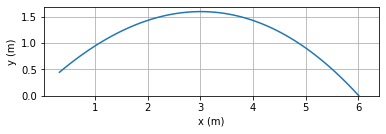

In [ ]:
plot_trajectory(displacement()[4],displacement()[5],ballvel(x_spring),np.deg2rad(angle))

In [ ]:
# plot initial velocity magnitude vs range
def plot_V0_vs_range(V0_min, V0_max, x_0=0, y_0=0, theta=np.deg2rad(45)):
    """
    Function accepts a minimum and a maximum initial velocity magnitude V0_min and V0_max, the initial position of the ball x_0 
    and y_0, and the initial angle between the velocity vector and the positive x-axis theta, and plots a graph showing how the 
    initial magnitude of velocity affects the total horizontal distance travelled by the ball
    """
    # return final horizontal distance travelled given a certain velocity magnitude
    def range(Vmag):
        x, y, Vx, Vy, t = trajectory_with_stop(x_0, y_0, Vmag, theta)
        return x[-1]
    
    # create array of initial velocity magnitudes
    V_mags = np.linspace(V0_min, V0_max, 20)
    
    # create array of total horizontal distances
    ranges = [range(V) for V in V_mags] 
    
    # plotting
    plt.figure(2)
    plt.plot(ranges, V_mags)
    plt.grid(1)
    plt.gca().set_aspect(1)
    plt.xlabel("Range (m)")
    plt.ylabel("Initial Velocity (m/s)")
    
    return None

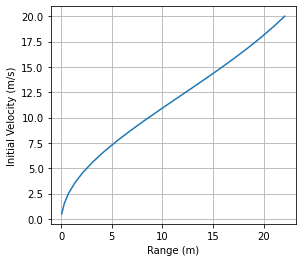

In [ ]:
plot_V0_vs_range(0.5, 20, x_0=0, y_0=0, theta=np.deg2rad(angle))

In [ ]:
# plot initial angle vs range (angle in degrees)
def plot_angle_vs_range(theta_min, theta_max, x_0, y_0, V_mag):
    """
    Function accepts a minimum and a maximum initial angle theta_min and theta_max in degrees, the initial position of the ball
    x_0 and y_0, and the initial velocity magnitude V_mag, and plots a graph showing how the initial angle between the velocity 
    vector and the positive x-axis affects the total horizontal distance travelled by the ball
    """
    # return final horizontal distance travelled given a certain angle in radians
    def range(thetha):
        x, y, Vx, Vy, t = trajectory_with_stop(x_0, y_0, V_mag, thetha)
        return x[-1]
    # create array of initial angles in degrees   
    thetas = np.linspace(theta_min, theta_max, 13)
    # create array of total horizontal distances
    ranges = [range(np.deg2rad(t)) for t in thetas] 
     
    # plotting    
    plt.figure(3)
    plt.plot(ranges, thetas)
    plt.grid(1)
    plt.xlabel("Range (m)")
    plt.ylabel("Initial Angle ($^\circ$)")
    return None

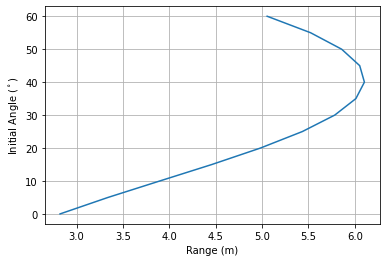

In [ ]:
plot_angle_vs_range(0, 60, x_0=displacement()[4], y_0=displacement()[5], V_mag=ballvel(x_spring))

In [ ]:
def estimator(target,x_0,y_0,tol_min=-0.01, tol_max=0.01,theta_min=15, theta_max=60):
  """
  estimate angle and spring compression length for target
  """
  for i in np.arange(0.05,0.175,0.005):
    i = float(i)
    # return final horizontal distance travelled given a certain angle in radians
    V_mag=ballvel(i)
    def range(thetha):
        x, y, Vx, Vy, t = trajectory_with_stop(x_0, y_0, V_mag, thetha)
        y_interp = np.interp(target, x, y)
        test.append(y_interp)
        return x, y
    test = []
    # create array of initial angles in degrees   
    thetas = np.linspace(theta_min, theta_max, 10)
    # create array of total horizontal distances
    ranges = [range(np.deg2rad(t))[0][-1] for t in thetas] 

    result = min(test, key=abs)
    result_index = test.index(result)
    # print(result)
    # print(thetas[result_index])
    if result >= tol_min and result <= tol_max:
      print("Solution at {}deg, {}m - error:{}".format(thetas[result_index],np.round(i,3),result))
      # plotting    
      plot_trajectory(x_0,y_0,ballvel(i),np.deg2rad(thetas[result_index]))
  return None

Solution at 55.0deg, 0.17m - error:-0.0035694542371004917


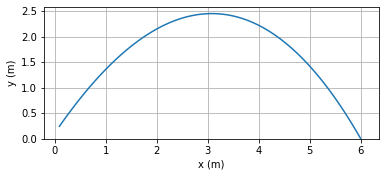

In [ ]:
estimator(target=6,x_0=0.09,y_0=0.245)